In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import glob
import math
from IPython.display import clear_output
from tqdm import tqdm
from itertools import count
import heapq
import warnings

warnings.filterwarnings('ignore')

In [35]:
Imgs = []
for file in glob.glob('Data/CameraModel/images/ho*'):
    Imgs.append(cv2.imread(file)[:,:,0])
Imgs = np.array(Imgs)

IntPnts = []
for file in glob.glob('Data/CameraModel/2D/house.0*ers'):
    file = open(file, 'r')
    pnts = file.read().split('\n')[:-1]
    pnts = np.array([ pnt.split() for pnt in pnts ]).astype(float).astype(int)
    IntPnts.append(pnts)
IntPnts = np.array(IntPnts)

file = open('Data/CameraModel/2D/house.nview-corners')
PntsCheck = file.read().split('\n')[:-1]
PntsCheck = np.array([ Pnt.split() for Pnt in PntsCheck ])
X, Y = np.where(PntsCheck == '*')
PntsCheck[X, Y] = '-1'
PntsCheck = PntsCheck.astype(int)

In [42]:
class DenseMatching():
    
    def __init__(self, img1, img2, points1, points2):
        self.Imgs = [img1, img2]
        self.points1 = points1
        self.points2 = points2
        self.H, self.W = Imgs[0].shape[:2]
        self.img1_check = np.zeros((self.H, self.W))
        self.img2_check = np.zeros((self.H, self.W))
        self.IntPnts = -1 * np.ones((self.H, self.W, 2))
        self.tiebreaker = count()
        
    def ZNCC(self, x, x_):
        
        if x.shape != x_.shape:
            return 0
        
        m_x = x - np.mean(x)
        m_x_ = x_ - np.mean(x_)
        
        num = np.sum(m_x * m_x_)
        den = math.sqrt(np.sum(m_x**2) * np.sum(m_x_**2))
        
        return num / den
    
    def Seed_Selection(self, w, thld_zncc_seed):
        self.Seeds = []
        pbar = tqdm(self.points1, total=self.points1.shape[0], leave=False)
        for p1 in pbar:
            pbar.set_description('Seed Selection Progress')
            for p2 in self.points2:
                x, y = p1
                x = self.Imgs[0][max(0, y-w) : min(self.H-1, y+w+1), max(0, x-w) : min(self.W-1, x+w+1)]
                x_, y_ = p2
                x_ = self.Imgs[1][max(0, y_-w) : min(self.H-1, y_+w+1), max(0, x_-w) : min(self.W-1, x_+w+1)]
                
                zncc = self.ZNCC(x, x_)
                if zncc > thld_zncc_seed:
                    heapq.heappush(self.Seeds, (1-zncc, next(self.tiebreaker), [p1, p2]))
                    #self.seed.append([p1, p2, zncc])
                    self.IntPnts[p1[1],p1[0]] = [p2[1],p2[0]]
                    self.img1_check[p1[1],p1[0]] = 1
                    self.img2_check[p2[1],p2[0]] = 1
        #self.seed = np.array(self.seed)
        #self.seed = self.seed[ np.argsort(self.seed[:,-1])[::-1] ]
    
    def Neighbor(self, X, N):
        x, y = X
        neigh = np.array(np.meshgrid(range(max(0, x-N), min(self.W-1, x+N+1)), range(max(0, y-N), min(self.H-1, y+N+1)))).T.reshape((-1, 2))
        return neigh
    
    def Neighbors(self, X, X_, N, epsilon):
        
        neigh_X = self.Neighbor(X, N)
        neigh_X_ = self.Neighbor(X_, N)
        X_neigh_X_ = []
        
        for U in neigh_X:
            for U_ in neigh_X_:
                if (U==X).all() and (U_==X_).all():
                    continue
                if np.linalg.norm((U - U_) - (X - X_), ord=np.inf) < epsilon:
                    X_neigh_X_.append([U, U_])
        
        return X_neigh_X_
    
    def confidence_score(self, pt, p, img):
        deltas = np.array([ [1, 0], [0, 1], [-1, 0], [0, -1] ])
        
        def fun(pt):
            pts = []
            for p in deltas:
                p = p + pt
                if p[0]>=0 and p[1]>=0 and p[0]<=self.W-1 and p[1]<=self.H-1:
                    pts.append(p)
            return np.array(pts)
        ps = fun(p)
        I = self.Imgs[img]
        confidence = max([ I[pt[1],pt[0]] - I[p[1],p[0]] for pt in ps]) / 255
        return confidence
    
    def convert_IntPnts_form(self):
        IntPnts1 = []
        IntPnts2 = []
        Y, X = np.where(self.IntPnts[:,:,0] != -1)
        for y, x in zip(Y, X):
            IntPnts1.append([y, x])
            y, x = self.IntPnts[int(y), int(x)]
            IntPnts2.append([y, x])
        self.IntPnts = np.array([IntPnts1, IntPnts2]).astype(int)
    
    def Propagation(self, thld_zncc_propagation=0.5, thld_confidence=0.01, w=2, N_window=2, epsilon=1):
        #IntPnts1 = []
        IntPnts = np.zeros((self.H, self.W, 2))
        #IntPnts2 = []
        #pbar = tqdm(self.Seeds, leave=False)
        #while len(self.Seeds) != 0:
        pbar = tqdm(range(self.H*self.W), leave=False)
        for i in pbar:
            pbar.set_description(f'Propagating on Seeds. Current Length of Seeds = {len(self.Seeds)}')
            _, _, (X, X_) = heapq.heappop(self.Seeds)
            neighbors = self.Neighbors(X, X_, N_window, epsilon)
            Local = []
            for neigh in neighbors:
                u, u_ = neigh
                if self.confidence_score(u, X, 0)>thld_confidence and self.confidence_score(u_, X_, 1)>thld_confidence:
                    x, y = u
                    x = self.Imgs[0][max(0, y-w) : min(self.H-1, y+w+1), max(0, x-w) : min(self.W-1, x+w+1)]
                    x_, y_ = u_
                    x_ = self.Imgs[1][max(0, y_-w) : min(self.H-1, y_+w+1), max(0, x_-w) : min(self.W-1, x_+w+1)]
                    zncc = self.ZNCC(x, x_)
                    if zncc > thld_zncc_propagation:
                        Local.append([u, u_, zncc])
            if len(Local) != 0:
                Local = np.array(Local)
                Local = Local[ np.argsort(Local[:,-1])[::-1] ]
                for pnt in Local:
                    u, u_, zncc = pnt
                    if not self.img1_check[u[1], u[0]] and not self.img2_check[u_[1], u_[0]]:
                        #IntPnts1.append(list(u))
                        #IntPnts2.append(list(u_))
                        self.IntPnts[u[1], u[0]] = [u_[1], u_[0]]
                        heapq.heappush(self.Seeds, (1-zncc, next(self.tiebreaker), [u, u_]))
                        self.img1_check[u[1], u[0]] = 1
                        self.img2_check[u_[1], u_[0]] = 1
            if len(self.Seeds) == 0:
                break
        self.convert_IntPnts_form()
        #self.IntPnts = np.array([IntPnts1, IntPnts2])
    
    def PerformDenseMatching(self, thld_zncc_seed=0.8, w_seed=5, thld_zncc_propagation=0.5, thld_confidence=0.01, w_propagation=2, N_window=2, epsilon_propagation=1):
        
        self.Seed_Selection(w_seed, thld_zncc_seed)
        self.Propagation(thld_zncc_propagation, thld_confidence, w_propagation, N_window, epsilon_propagation)

In [43]:
temp = DenseMatching(Imgs[0], Imgs[1], IntPnts[0], IntPnts[1])
temp.PerformDenseMatching()

Before Dense Matching


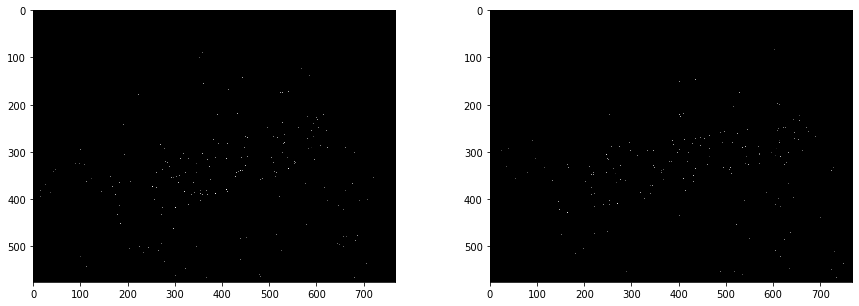

After Dense Matching


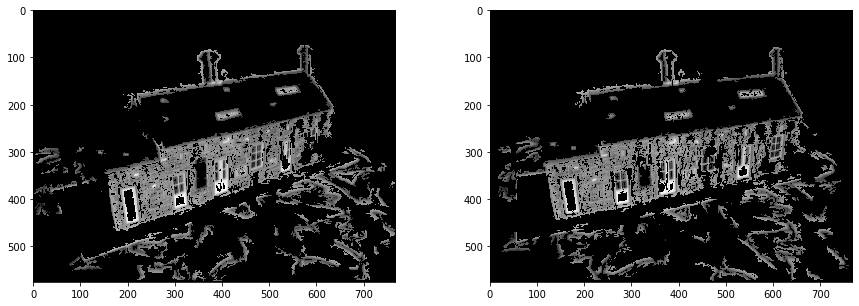

In [44]:
print('Before Dense Matching')
ImgPnts1 = np.zeros((temp.H, temp.W))
ImgPnts1[IntPnts[0][:,1], IntPnts[0][:,0]] = 1
ImgPnts2 = np.zeros((temp.H, temp.W))
ImgPnts2[IntPnts[1][:,1], IntPnts[1][:,0]] = 1

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(Imgs[0]*ImgPnts1, cmap='gray')
axs[1].imshow(Imgs[1]*ImgPnts2, cmap='gray')
plt.show()

print('After Dense Matching')
ImgPnts1 = np.zeros((temp.H, temp.W))
ImgPnts1[temp.IntPnts[0][:,0], temp.IntPnts[0][:,1]] = 1
ImgPnts2 = np.zeros((temp.H, temp.W))
ImgPnts2[temp.IntPnts[1][:,0], temp.IntPnts[1][:,1]] = 1

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(Imgs[0]*ImgPnts1, cmap='gray')
axs[1].imshow(Imgs[1]*ImgPnts2, cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


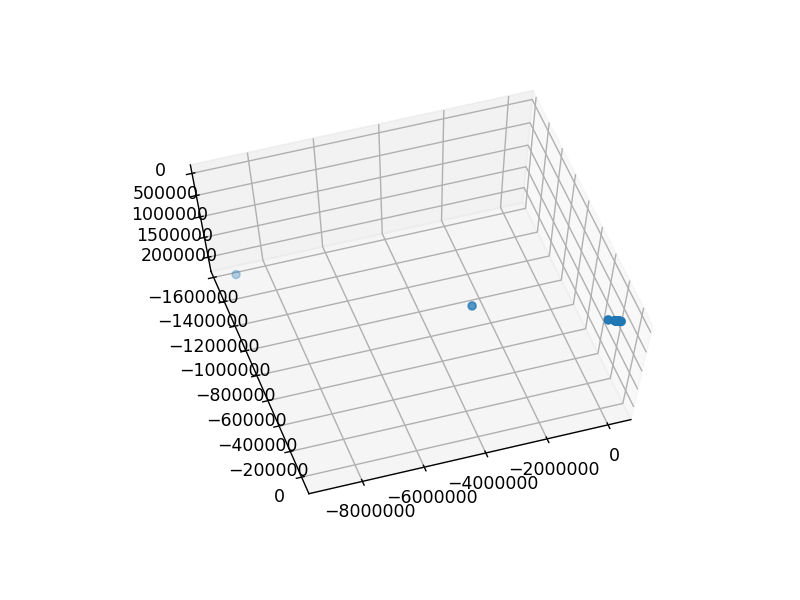

In [30]:
%matplotlib notebook
t = np.load('../pnts.npy')
#np.around(t, 4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(t[:,0], t[:,1], t[:,2])

In [26]:
import open3d
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(np.around(t, 4))
open3d.visualization.draw_geometries([pcd])

RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 